# RECAPを使った分解

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/delaney-solubility/delaney-processed.csv')
df.sample(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
639,3-Hexyne,-1.933,1,82.146,0,0,0,0.00,-1.99,CCC#CCC
925,RTI 6,-3.335,1,313.361,2,3,4,81.59,-3.36,CCN2c1nc(N(C)(CCO))ccc1NC(=O)c3cccnc23
692,"2,3,4-Trichlorophenol",-3.705,1,197.448,1,1,0,20.23,-2.67,Oc1ccc(Cl)c(Cl)c1Cl


In [3]:
import rdkit 
print('rdkit version', rdkit.__version__)
from rdkit.Chem import MolFromSmiles, Descriptors

rdkit version 2018.03.4


In [4]:
df['mol'] = df['smiles'].apply(MolFromSmiles)

## ReCAPの階層構造可視化

In [5]:
index_maxmolwt = df['mol'].apply(dict(Descriptors.descList)['MolWt']).argmax()
df['mol'].iloc[index_maxmolwt]

c:\users\shojiro_shibayama\miniconda3\envs\cheminfo\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [6]:
base_mol = df['mol'].iloc[index_maxmolwt]

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Recap

In [8]:
decomp = Recap.RecapDecompose(base_mol)
layer1 = [node.mol for node in decomp.children.values()]

## 再帰関数によるSMILESの表示

In [9]:
def dump_leaves(recap_root, n_nests=1):
    for leaf in recap_root.children.values():
        print('  > '*(n_nests-1) + leaf.smiles)
        dump_leaves(leaf, n_nests=n_nests+1)

dump_leaves(decomp)

*C1CC(O)C(O)C(C)O1
*C1C(O)CC(OC2C(O)CC(OC3CCC4(C)C(CCC5C4CC(O)C4(C)C(C6=CC(=O)OC6)CCC54O)C3)OC2C)OC1C
  > *C1CC(O)C(*)C(C)O1
  > *C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C
  >   > *C1CC(O)C(*)C(C)O1
  >   > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
  > *C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
  > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
*C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1
  > *C1CC(O)C(*)C(C)O1
  > *C1CC(O)C(O)C(C)O1
*C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C
  > *C1CC(O)C(*)C(C)O1
  > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
*C1CC(O)C(OC2CC(O)C(OC3CC(O)C(O)C(C)O3)C(C)O2)C(C)O1
  > *C1CC(O)C(*)C(C)O1
  > *C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
  >   > *C1CC(O)C(O)C(C)O1
  > *C1CC(O)C(O)C(C)O1
  > *C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
*C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1


In [10]:
from pprint import pprint

## 取り出したフラグメントの数え上げ

In [11]:
def extract(ret, parent):
    for child in parent.children.values():
        ret += [child.smiles]
        extract(ret, child)
list_recap=[]
extract(list_recap, decomp)
print('取り出された全てのフラグメント', len(set(list_recap)))
pprint(set(list_recap))

取り出された全てのフラグメント 8
{'*C1C(O)CC(OC2C(O)CC(OC3CCC4(C)C(CCC5C4CC(O)C4(C)C(C6=CC(=O)OC6)CCC54O)C3)OC2C)OC1C',
 '*C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C',
 '*C1CC(O)C(*)C(C)O1',
 '*C1CC(O)C(O)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(OC3CC(O)C(O)C(C)O3)C(C)O2)C(C)O1',
 '*C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1'}


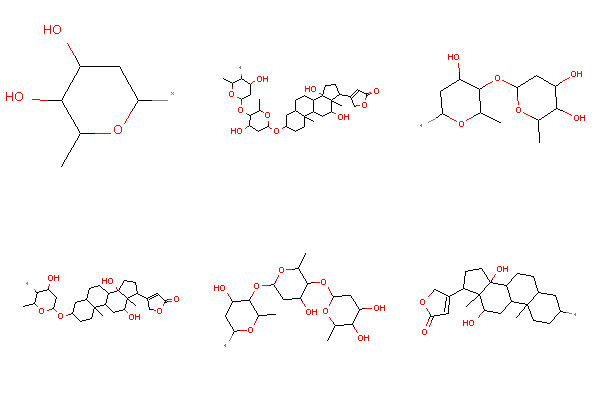

In [12]:
Draw.MolsToGridImage(layer1, molsPerRow=3)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
molwt = lambda m:dict(Descriptors.descList)['MolWt'](m)

## 分子1構造のRECAPフラグメントネットワークの可視化

... 今回のサンプルでは複数のフラグメントが同じフラグメントに収束することが分かる

9


c:\users\shojiro_shibayama\miniconda3\envs\cheminfo\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\users\shojiro_shibayama\miniconda3\envs\cheminfo\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


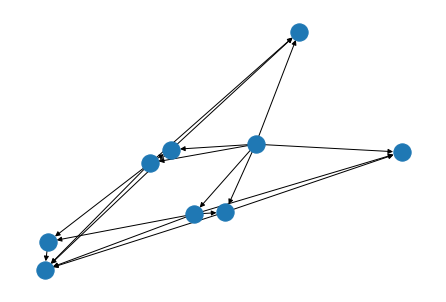

In [15]:
D = nx.DiGraph()
from copy import deepcopy 

def grow_leaves(G, parent, n_levels=1):
    if n_levels==1:
        G.add_node(parent.smiles)
    if parent.children:
        for leaf in parent.children.values():
            properties = {
                'smiles':leaf.smiles, 
                'molwt': molwt(leaf.mol),
            }
            G.add_edge(parent.smiles, leaf.smiles,
                       **properties)
            grow_leaves(G, leaf, n_levels+1)
    return G
parent = deepcopy(decomp)
grow_leaves(D, decomp)
print(len(D))

nx.draw(D)
plt.show()

In [16]:
colors=['r']+['g']*(len(D)-1)
colors # 木の最初(親ノード)だけを赤、それ以外を緑で色付けする準備

['r', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g']

In [17]:
nx.__version__

'2.3'

In [27]:
# list(D)
from rdkit.Chem.Draw import IPythonConsole 

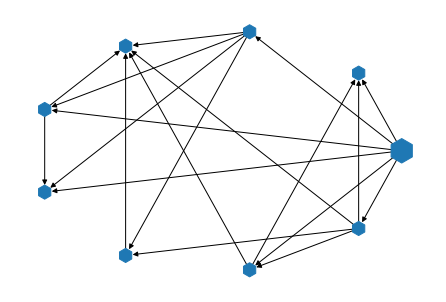

In [32]:
smiles_parent = Chem.MolToSmiles(decomp.mol)
list_sizes=[600 if smi == smiles_parent else 200 for smi in list(D)]
nx.draw_circular(D, node_shape='h', node_size=list_sizes) # node_color=colors, 
plt.show()